In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: Kumar Ankit
- PRN : 240840128022
- Date: 

# Image Processing with Neural Network
## Assignment A05

## Tensor Flow
- Select number of layers
- Select node in each of the layers
- Choose activation function
- multi-class - Fashion MNIST dataset (all 60000 images)
- Implement one or more of following to achieve max accuracy.
    - L1/ L2 Regularization
    - Dropout
    - Batch Normalization
    - Early stopping
- Save model

In [4]:
###-----------------
### Import Libraries
###-----------------
import os
import sys
import time
import numpy as np
import pandas as pd
import gc

import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

parent_dir = os.path.abspath('..')
sys.path.insert(0, parent_dir)


from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [5]:
###-----------------
### Global Variables
###-----------------
inpDir = os.path.join('..', 'input')
outDir = '../output'
modelDir = '../models'
subDir = 'fashion_mnist'
altName = 'A04_fashion_vanila'

TEST_SIZE = .2

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)


In [6]:
###-----------------
### Hyper Parameters
###-----------------

EPOCHS = 30 # number of epochs
ALPHA = 0.001 # learning rate
BATCH_SIZE = 64 # mini batch size (number of rows)

## Load Fashion MNIST dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing you'll use here.

This guide uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [9]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [11]:
train_df['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

In [12]:
train_df.isna().sum().sum() # null value not a problem in images

0

In [13]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

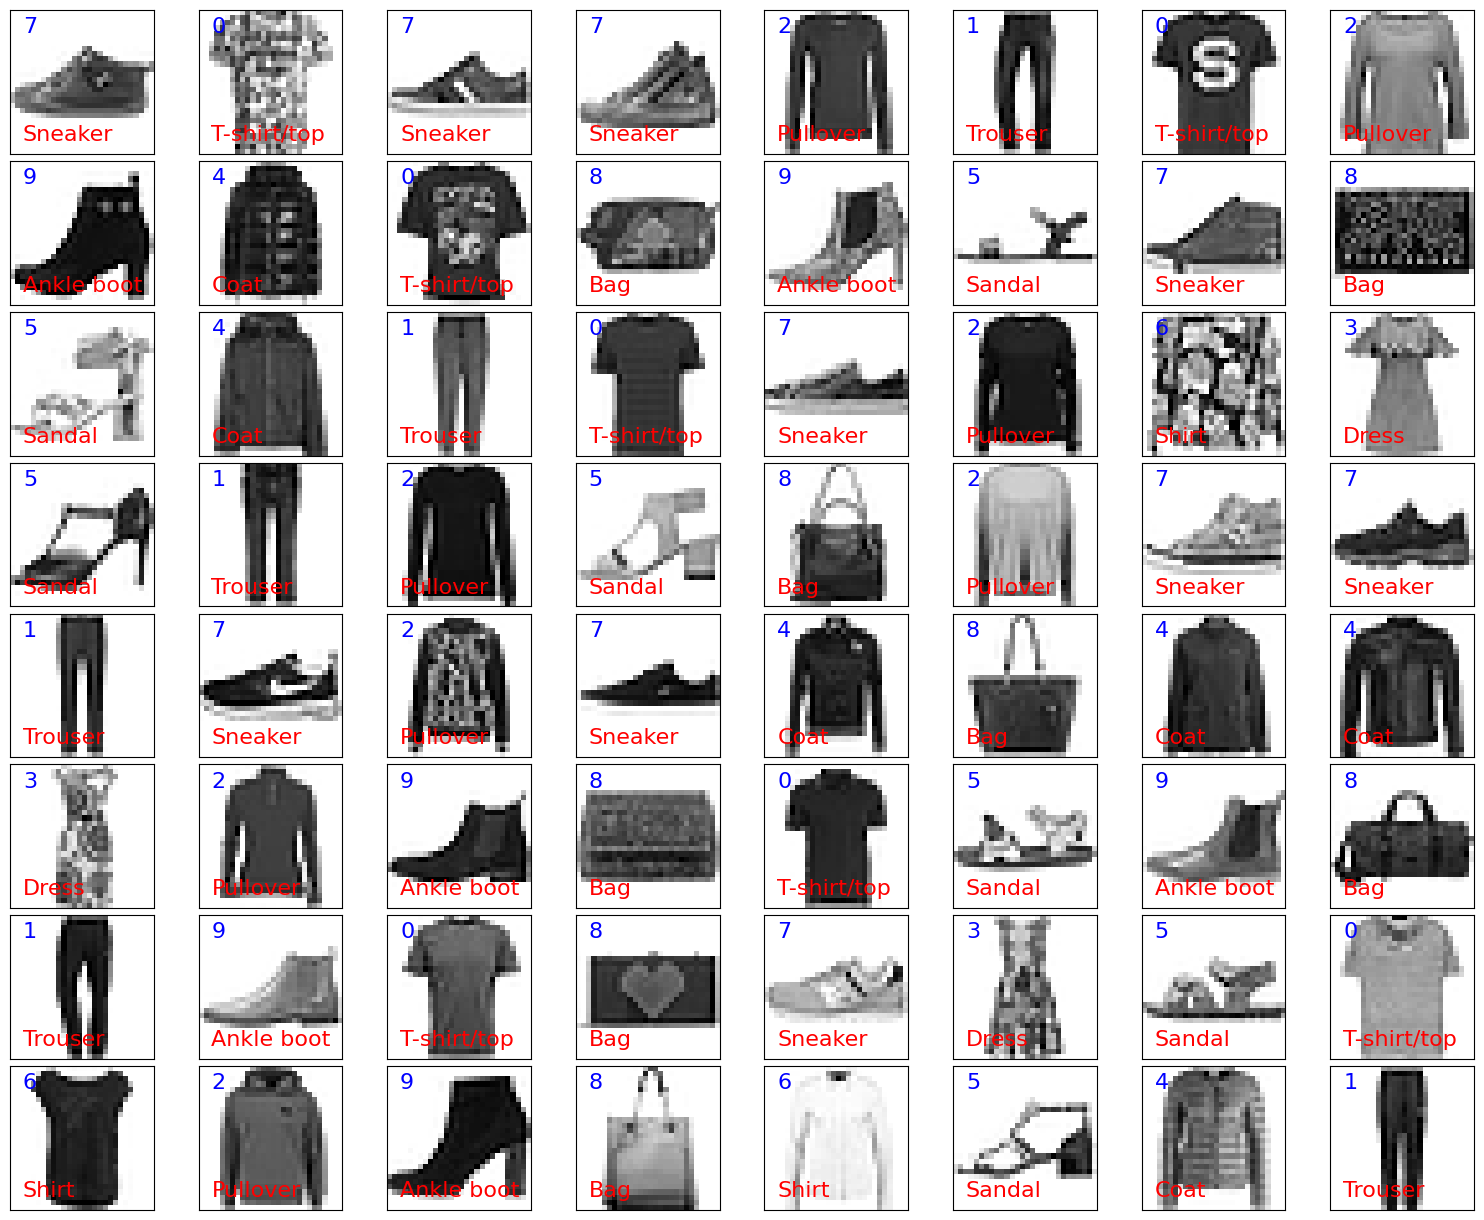

In [14]:
# sample data plot: display a grid of images from the dataset along with their labels

n_rows = 8 # number of rows to display in the grid
n_cols = 8 # number of columns to display in grid

# randomly sample n_rows * n_cols images from the dataset
plot_df = train_df.sample(n = n_rows*n_cols)

# create a new figure for the grid of images with specified sizes
fig = plt.figure(figsize = (15, 12))

# adjust spacing between subplots to eliminate gaps
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

# initialize the subplot index
i = 0

# iterate through each row of teh sampled dataframe

for idx, row in plot_df.iterrows():

    i += 1 # incrimant subplot index

    # reshaping the row values (excluding the first columns) into a 28*28 matirx(image dimensions as given))
    image = row.values[1:].reshape(28,28)

    ax = fig.add_subplot(n_rows, n_cols, (i), xticks = [], yticks = []) # No ticks for a clean plot 

    # display the image on the subplot using a binary colormap
    ax.imshow(image, cmap = plt.cm.binary, interpolation = 'nearest')
    
    # add the numeric label of the image in blue text at a specific possition
    ax.text(2, 4, str(row.iloc[0]), color = 'b', fontsize = 16)

    # add the class nameof the image in red text below the numeric label
    ax.text(2, 25, class_names[row.iloc[0]], color = 'r', fontsize = 16)

# display the entire grid of images
plt.show()

### splitting data

In [16]:
train_df['label'] = pd.to_numeric(train_df['label'], downcast = 'integer')
test_df['label'] = pd.to_numeric(test_df['label'], downcast = 'integer')

In [17]:
X_train = train_df.drop('label', axis = 1).to_numpy()
X_test = train_df.label

X_train, X_test, y_train, y_test = train_test_split(X_train, X_test, test_size = TEST_SIZE, stratify = X_test, random_state = RANDOM_STATE)

train_shape = X_train.shape

In [18]:
X_train = X_train / 255.0 # dividing by 255 for scaling

X_test = X_test / 255.0

X_valid = test_df / 255.0

In [19]:

X_valid = test_df.drop('label', axis = 1)


y_valid = test_df.label

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48000, 784), (12000, 784), (48000,), (12000,))

### converting dataset into tensor

In [22]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [23]:
train_shape = X_train.shape
test_shape = X_test.shape
valid_shape = X_valid.shape

### shuffle and batch the dataset
- By chaining these operations (shuffle and batch), the dataset is first shuffled
- and then divided into batches, making it ready for training.

In [25]:
train_ds = train_ds.shuffle(buffer_size= train_shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size= test_shape[0]).batch(BATCH_SIZE)
valid_ds= valid_ds.shuffle(buffer_size = valid_shape[0]).batch(BATCH_SIZE)

### Optimise the performance
- Cache the data to avoid reduntant processing
- Repeat the dataset for multiple epochs
- Prefetch data to overlap preprocessing and model execution


In [27]:
# `prefetch()` improves performance by preparing data for the next batch whike the model is still training on the current batch. 
# It essentially overlaps the proces of data loading with model training.
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
del train_df, test_df # to save memory we can delete unwanted dataFrames
gc.collect()
gc.collect()
# This is because certain objects might become unreachable only after other objects are deleted during the first collection.
# A second pass ensures that such "indirectly" orphaned objects are also handled.

0

# prepare model

#### functional api
- 784/2 = 392
- 392/2 = 196
- 196/2 = 96
- 96/2 = 48
  

In [31]:
initializer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE) # weight initializer for a neural network layer in TensorFlow/Keras using the Glorot Uniform Initialization

optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

## definin gregularizer

regularizer = tf.keras.regularizers.L2(.05) # tune reg lambda

In [32]:
inputs = tf.keras.Input(shape = (train_shape[1], ), name = 'input')

x = tf.keras.layers.Dense(196, activation = tf.keras.activations.relu,
                          kernel_initializer = initializer, kernel_regularizer = regularizer, name= 'fc_1')(inputs)
x = tf.keras.layers.Dense(49, activation = tf.keras.activations.relu,
                          kernel_initializer = initializer, kernel_regularizer = regularizer, name = 'fc_2')(x) # it can be understood like a linked list
outputs = tf.keras.layers.Dense(10 ,
                                kernel_initializer = initializer, kernel_regularizer = regularizer, name= 'output')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'MINST')

In [33]:
model.summary()

Model: "MINST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 196)            │       153,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 49)             │         9,653 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,013 (640.68 KB)

 Trainable params: 164,013 (640.68 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)
model.compile(optimizer = optimizer, loss= loss_fn, metrics = ['accuracy'])

In [35]:
history = model.fit(train_ds, validation_data= test_ds, epochs = EPOCHS, verbose = 2)

Epoch 1/30
750/750 - 6s - 9ms/step - accuracy: 0.6585 - loss: 2.6494 - val_accuracy: 0.6545 - val_loss: 1.6623
Epoch 2/30
750/750 - 4s - 5ms/step - accuracy: 0.6771 - loss: 1.6370 - val_accuracy: 0.6747 - val_loss: 1.6215
Epoch 3/30
750/750 - 4s - 6ms/step - accuracy: 0.6967 - loss: 1.6077 - val_accuracy: 0.6948 - val_loss: 1.5991
Epoch 4/30
750/750 - 4s - 6ms/step - accuracy: 0.7052 - loss: 1.5867 - val_accuracy: 0.7030 - val_loss: 1.5796
Epoch 5/30
750/750 - 5s - 6ms/step - accuracy: 0.7070 - loss: 1.5737 - val_accuracy: 0.7049 - val_loss: 1.5656
Epoch 6/30
750/750 - 3s - 5ms/step - accuracy: 0.7096 - loss: 1.5666 - val_accuracy: 0.7060 - val_loss: 1.5580
Epoch 7/30
750/750 - 4s - 6ms/step - accuracy: 0.7114 - loss: 1.5620 - val_accuracy: 0.7078 - val_loss: 1.5544
Epoch 8/30
750/750 - 4s - 6ms/step - accuracy: 0.7122 - loss: 1.5588 - val_accuracy: 0.7096 - val_loss: 1.5533
Epoch 9/30
750/750 - 4s - 6ms/step - accuracy: 0.7124 - loss: 1.5562 - val_accuracy: 0.7121 - val_loss: 1.5520
E

In [36]:
hist_df = pd.DataFrame(history.history)

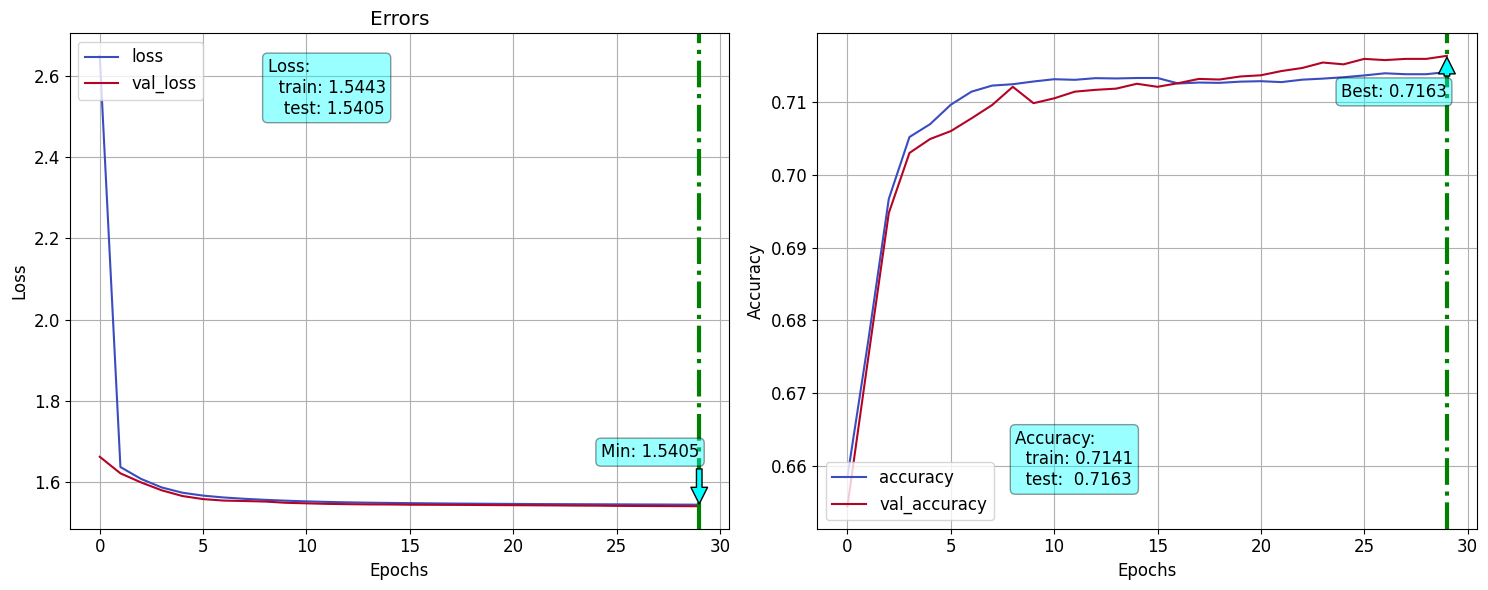

In [37]:
fn_plot_tf_hist(hist_df=hist_df)

In [ ]:
## minimum will be on last value of epoch in case of regularization because 